In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

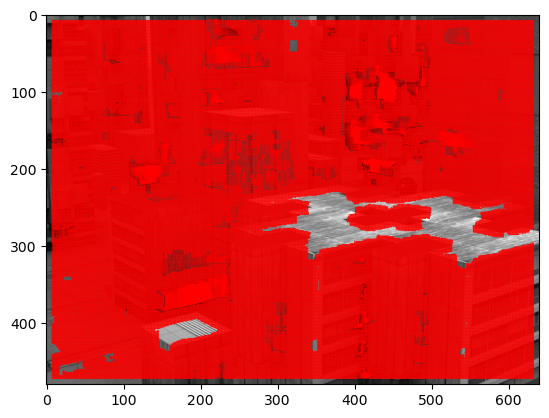

In [6]:
def lucas_kanade(prev_img, curr_img, window_size=15):
    # Define the gradient kernels
    gradient_x = np.array([[-1, 1], [-1, 1]])
    gradient_y = np.array([[-1, -1], [1, 1]])
    gradient_t = np.array([[-1, -1], [-1, -1]])

    # Calculate the image gradients
    I_x = cv2.filter2D(prev_img, -1, gradient_x) + cv2.filter2D(curr_img, -1, gradient_x)
    I_y = cv2.filter2D(prev_img, -1, gradient_y) + cv2.filter2D(curr_img, -1, gradient_y)
    I_t = cv2.filter2D(prev_img, -1, gradient_t) + cv2.filter2D(curr_img, -1, -gradient_t)

    # Define the window for computing the optical flow
    half_window = window_size // 2

    # Initialize the motion flow vectors to zero
    motion_flow = np.zeros(prev_img.shape + (2,))

    # Loop over all pixels in the image
    for i in range(half_window, prev_img.shape[0] - half_window):
        for j in range(half_window, prev_img.shape[1] - half_window):
            # Extract the image patch around the pixel
            I_x_patch = I_x[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            I_y_patch = I_y[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            I_t_patch = I_t[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()

            # Compute the optical flow using the least-squares method
            A = np.stack((I_x_patch, I_y_patch), axis=-1)
            b = -I_t_patch
            v, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            motion_flow[i, j] = v

    return motion_flow

# Load the previous and current images
# prev_img = cv2.imread('input_images/TestSeq/Shift0.png', cv2.IMREAD_GRAYSCALE)
# curr_img = cv2.imread('input_images/TestSeq/ShiftR2.png', cv2.IMREAD_GRAYSCALE)

# Load the previous and current images
prev_img = cv2.imread('input_images/Urban2/urban01.png', cv2.IMREAD_GRAYSCALE)
curr_img = cv2.imread('input_images/Urban2/urban02.png', cv2.IMREAD_GRAYSCALE)

# Compute the motion flow using Lucas-Kanade algorithm
motion_flow = lucas_kanade(prev_img, curr_img)

# Plot the non-zero motion flow vectors using matplotlib
y, x = np.mgrid[0:curr_img.shape[0], 0:curr_img.shape[1]]
mag = np.linalg.norm(motion_flow, axis=-1)
mask = mag > 0.1  # Define a threshold to filter out low-magnitude vectors
plt.imshow(curr_img, cmap='gray')
plt.quiver(x[mask], y[mask], motion_flow[..., 0][mask], motion_flow[..., 1][mask], color='r')
plt.show()



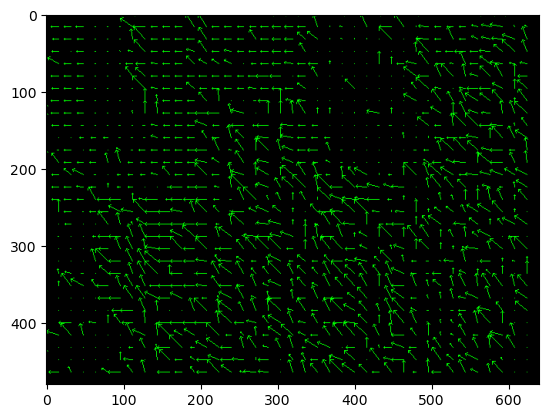

In [12]:
def calculate_motion_flow(frame1, frame2, block_size, search_range):
    # Convert frames to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Define motion vector field
    motion_flow = np.zeros_like(frame1)

    # Divide first frame into blocks
    for i in range(0, gray1.shape[0], block_size):
        for j in range(0, gray1.shape[1], block_size):
            # Define current block
            block1 = gray1[i:i+block_size, j:j+block_size]

            # Define search area in second frame
            top = max(i-search_range, 0)
            bottom = min(i+search_range, gray2.shape[0])
            left = max(j-search_range, 0)
            right = min(j+search_range, gray2.shape[1])
            search_area = gray2[top:bottom, left:right]

            # Calculate correlation between block and search area
            corr = cv2.matchTemplate(search_area, block1, cv2.TM_CCORR_NORMED)

            # Find location of maximum correlation
            y, x = np.unravel_index(np.argmax(corr), corr.shape)

            # Calculate motion vector
            dx = x + left - j
            dy = y + top - i

            # Draw motion vector on image
            cv2.arrowedLine(motion_flow, (j, i), (j+dx, i+dy), (0, 255, 0), 1, tipLength=0.2)
    
    return motion_flow

# Read two consecutive frames
frame1 = cv2.imread('input_images/Urban2/urban01.png')
frame2 = cv2.imread('input_images/Urban2/urban02.png')
        
# Define block size and search range
block_size = 16
search_range = 16

# Calculate motion flow
motion_flow = calculate_motion_flow(frame1, frame2, block_size, search_range)

# Display motion vector field
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(motion_flow, cv2.COLOR_BGR2RGB))
plt.show()